<a href="https://colab.research.google.com/github/yashveersinghsohi/Kaggle_Competitions/blob/HousePrice/House%20Prices/Submissions/Sub%204%20-%20Boosting%20and%20Stacking/Sub_4_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Required Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import BaggingRegressor

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor

#  Reading Data

In [2]:
url = "https://raw.githubusercontent.com/yashveersinghsohi/Kaggle_Competitions/HousePrice/House%20Prices/Submissions/Data/"

train_df = pd.read_csv(url + "train.csv")
test_df = pd.read_csv(url + "test.csv")

train_features_df = pd.read_csv(url + "train_features_df.csv")
test_features_df = pd.read_csv(url + "test_features_df.csv")

# train_df = pd.read_csv("train.csv")
# test_df = pd.read_csv("test.csv")

# train_features_df = pd.read_csv("train_features_df.csv")
# test_features_df = pd.read_csv("test_features_df.csv")

In [3]:
train_features_df.head()

,OverallQual,ExterQual,Foundation,BsmtQual,KitchenQual,FireplaceQu,GarageFinish,YearDiff,YearRemodAdd,1stFlrSF,GrLivArea,FullBath,GarageCars,Neighborhood,MasVnrType,HeatingQC,Fireplaces,MasVnrArea,GarageYrBlt,HouseStyle,Exterior1st,Exterior2nd,BsmtExposure,BsmtFinType1,GarageType,OverallCond,LotArea,BsmtFinSF1,LotFrontage,2ndFlrSF,SalePrice,no_garage,is_BsmtFinSF1_0,is_2ndFlrSF_0
0,7,2,6,3,2,1,2,2.472136,87.509776,6.752270,7.444249,2,2,16,2,4,0,196.0,2003,6,11,13,1,6,5,8,9.041922,706,4.174387,854,208500,0,0,0
1,6,1,3,3,1,3,2,9.135529,86.904443,7.140453,7.140453,2,2,19,1,4,1,0.0,1976,4,6,4,4,4,5,4,9.169518,978,4.382027,0,181500,0,0,1
2,7,2,6,3,2,3,2,3.291503,87.487429,6.824374,7.487734,2,2,16,2,4,1,162.0,2001,6,11,13,2,6,5,8,9.328123,486,4.219508,866,223500,0,0,0
3,7,1,2,2,2,4,1,17.078784,86.769364,6.867974,7.448334,1,3,18,1,3,1,0.0,1998,6,5,3,1,4,2,8,9.164296,216,4.094345,756,140000,0,0,0
4,8,2,6,3,2,3,2,3.656854,87.442719,7.043160,7.695303,2,3,23,2,4,1,350.0,2000,6,11,13,3,6,5,8,9.565214,655,4.430817,1053,250000,0,0,0


In [4]:
test_features_df.head()

,OverallQual,ExterQual,Foundation,BsmtQual,KitchenQual,FireplaceQu,GarageFinish,YearDiff,YearRemodAdd,1stFlrSF,GrLivArea,FullBath,GarageCars,Neighborhood,MasVnrType,HeatingQC,Fireplaces,MasVnrArea,GarageYrBlt,HouseStyle,Exterior1st,Exterior2nd,BsmtExposure,BsmtFinType1,GarageType,OverallCond,LotArea,BsmtFinSF1,LotFrontage,2ndFlrSF,no_garage,is_BsmtFinSF1_0,is_2ndFlrSF_0
0,5,1,3,2,1,1,1,12.000000,86.566359,6.797940,6.797940,1,1,9,1,2,0,0.0,7.581210,4,11,13,1,3,5,6,9.360655,468.0,4.382027,0,0,0,1
1,6,1,3,2,2,1,1,12.422205,86.498588,7.192182,7.192182,1,1,9,2,2,0,108.0,7.579679,4,5,2,1,4,5,6,9.565704,923.0,4.394449,0,0,0,1
2,5,1,6,3,1,3,3,5.211103,87.397987,6.833032,7.395722,2,2,13,1,3,1,0.0,7.599401,6,11,13,1,6,5,5,9.534595,791.0,4.304065,701,0,0,0
3,6,1,6,2,2,4,3,4.928203,87.397987,6.830874,7.380256,2,2,13,2,4,1,20.0,7.599902,6,11,13,1,6,5,6,9.208138,602.0,4.356709,678,0,0,0
4,8,2,6,3,2,1,2,6.485281,87.263654,7.154615,7.154615,2,2,22,1,4,0,0.0,7.596894,4,8,8,1,4,5,5,8.518193,263.0,3.761200,0,0,0,1


# Train Test Split

In [5]:
def split_data(df, test_size = 0.2, random_state = 42):
    X, y = df.drop(["SalePrice"], axis = 1), df["SalePrice"]
    return train_test_split(X, y, test_size = test_size, random_state = random_state)

# Adaboost Regressor

## Base AdaBoost Regressor

**Model**

In [ ]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
ada = AdaBoostRegressor(random_state = 42).fit(X_train, np.log(y_train))
ada_preds = np.exp(ada.predict(X_test))

**RMSLE**

In [ ]:
np.sqrt(mean_squared_log_error(y_true = y_test, y_pred  = ada_preds))

0.17253553560633222

## GridSearchCV

**Defining Grid**

In [ ]:
base_ada = AdaBoostRegressor(random_state = 42)
params = {
    "learning_rate": [0.01, 0.03, 0.1, 0.3, 1, 3, 10],
    "n_estimators": [50, 75, 100, 150, 200, 300, 500, 1000],
    "loss": ["linear", "square", "exponential"]
}

grid = GridSearchCV(estimator = base_ada, 
                    param_grid = params, 
                    scoring = "neg_mean_squared_log_error", 
                    cv = 3, 
                    verbose = 3, 
                    n_jobs = -1)

**Fitting Grid**

In [ ]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
ada_grid = grid.fit(X_train, np.log(y_train))

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:  5.5min finished


**Best AdaBoost from GridSearchCV**

In [ ]:
np.sqrt(mean_squared_log_error(y_true = y_test, 
                               y_pred = np.exp(ada_grid.best_estimator_.predict(X_test))))

0.17287705642165474

# GBM Regressor

## Base GBM Regressor

In [ ]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
gbm = GradientBoostingRegressor(random_state = 42).fit(X_train, np.log(y_train))
gbm_preds = np.exp(gbm.predict(X_test))

In [ ]:
np.sqrt(mean_squared_log_error(y_true = y_test, 
                               y_pred = gbm_preds))

0.13628312366698758

## GridSearchCV

### Preliminary Optimization of Boosting parameters

- **learning_rate**
- **n_estimators**

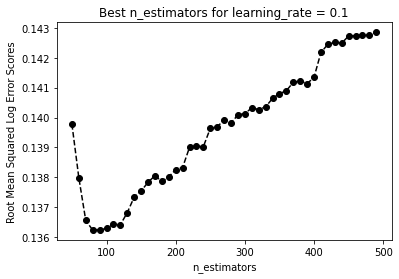

In [ ]:
ns = np.arange(50, 500, 10)
gbm_scores = []

X_train, X_test, y_train, y_test = split_data(train_features_df)
for n in ns:
  gbm = GradientBoostingRegressor(learning_rate = 0.1, 
                                  n_estimators = n, 
                                  random_state = 42).fit(X_train, np.log(y_train))
  
  gbm_preds = np.exp(gbm.predict(X_test))
  gbm_rmsle = np.sqrt(mean_squared_log_error(y_true = y_test, y_pred = gbm_preds))
  gbm_scores.append(gbm_rmsle)

fig, ax = plt.subplots()
ax.plot(ns, gbm_scores, marker = "o", linestyle = "--", color = "k")
ax.set(xlabel = "n_estimators", 
       ylabel = "Root Mean Squared Log Error Scores", 
       title = "Best n_estimators for learning_rate = 0.1")
plt.show()

RESULTS
Number of estimators:  80
Learning Rate:  0.1
Root Mean Squarred Log Error:  0.1362312022198972


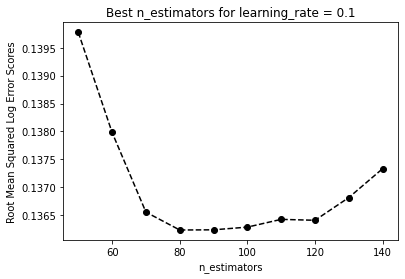

In [ ]:
min_idx = np.argmin(np.array(gbm_scores))
print("RESULTS")
print("Number of estimators: ", ns[min_idx])
print("Learning Rate: ", 0.1)
print("Root Mean Squarred Log Error: ", gbm_scores[min_idx])

fig, ax = plt.subplots()
ax.plot(ns[:10], gbm_scores[:10], marker = "o", linestyle = "--", color = "k")
ax.set(xlabel = "n_estimators", 
       ylabel = "Root Mean Squared Log Error Scores", 
       title = "Best n_estimators for learning_rate = 0.1")
plt.show()

### Optimizing Tree Based Parameters

- **subsample**
- **min_samples_split**
- **min_samples_leaf**
- **max_depth**
- **max_features**

In [ ]:
base_gbm = GradientBoostingRegressor(random_state = 42, 
                                     learning_rate = 0.1, 
                                     n_estimators = 80)
params = {
    "subsample": [0.8, 0.9, 1.0],
    "min_samples_split": [25, 50, 75],
    "min_samples_leaf": [5, 10, 15],
    "max_depth": [4, 5, 6],
    "max_features": [12, 18, 24, 30]
}

grid = GridSearchCV(estimator = base_gbm, 
                    param_grid = params, 
                    scoring = "neg_mean_squared_log_error", 
                    cv = 3, 
                    verbose = 3, 
                    n_jobs = -1)

In [ ]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
gbm_grid = grid.fit(X_train, np.log(y_train))

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:  2.2min finished


In [ ]:
gbm_grid.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=12, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=25,
                          min_weight_fraction_leaf=0.0, n_estimators=80,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
np.sqrt(mean_squared_log_error(y_true = y_test, 
                               y_pred = np.exp(gbm_grid.best_estimator_.predict(X_test))))

0.1420816075162319

### Final Model

In [ ]:
gbm_grid.best_params_

{'max_depth': 6,
 'max_features': 12,
 'min_samples_leaf': 10,
 'min_samples_split': 25,
 'subsample': 1.0}

In [ ]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
best_gbm_model = GradientBoostingRegressor(max_depth = 6, 
                                           max_features = 12, 
                                           min_samples_leaf = 10, 
                                           min_samples_split = 25, 
                                           subsample = 1.0, 
                                           learning_rate = 0.001, 
                                           n_estimators = 8000, 
                                           random_state = 42).fit(X_train, np.log(y_train))

base_gbm = GradientBoostingRegressor(learning_rate = 0.1, 
                                     n_estimators = 80, 
                                     random_state = 42).fit(X_train, np.log(y_train))

best_gbm_preds = np.exp(best_gbm_model.predict(X_test))
best_gbm_rmsle = np.sqrt(mean_squared_log_error(y_true = y_test, y_pred = best_gbm_preds))

base_gbm_preds = np.exp(base_gbm.predict(X_test))
base_gbm_rmsle = np.sqrt(mean_squared_log_error(y_true = y_test, y_pred = base_gbm_preds))

In [ ]:
best_gbm_rmsle

0.13980079971568782

In [ ]:
base_gbm_rmsle

0.1362312022198972

# Submission for GBM

**Optimized GBM**

In [ ]:
X, y = train_features_df.drop(["SalePrice"], axis = 1), train_features_df["SalePrice"]
final_gbm_op_model = GradientBoostingRegressor(max_depth = 6, 
                                               max_features = 12, 
                                               min_samples_leaf = 10, 
                                               min_samples_split = 25, 
                                               subsample = 1.0, 
                                               learning_rate = 0.001, 
                                               n_estimators = 8000, 
                                               random_state = 42).fit(X.values, np.log(y.values))
final_gbm_op_preds = np.exp(final_gbm_op_model.predict(test_features_df.values))

In [ ]:
sub4_gbm_op = pd.read_csv(url + "sample_submission.csv")
sub4_gbm_op["SalePrice"] = final_gbm_op_preds
sub4_gbm_op.to_csv("sub4_gbm_op.csv", index = False)

**Base GBM**

In [ ]:
X, y = train_features_df.drop(["SalePrice"], axis = 1), train_features_df["SalePrice"]
final_gbm_model = GradientBoostingRegressor(n_estimators = 80, 
                                            learning_rate = 0.1, 
                                            random_state = 42).fit(X.values, np.log(y.values))
final_gbm_preds = np.exp(final_gbm_model.predict(test_features_df.values))

In [ ]:
sub4_gbm = pd.read_csv(url + "sample_submission.csv")
sub4_gbm["SalePrice"] = final_gbm_preds
sub4_gbm.to_csv("sub4_gbm.csv", index = False)

# XGBoost

## Base XGBoost

In [ ]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
base_xgb = xgb.XGBRegressor(random_state = 42).fit(X_train, np.log(y_train), 
                                                   early_stopping_rounds = 10, 
                                                   eval_metric = "rmse", 
                                                   eval_set = [(X_test, np.log(y_test))])
base_xgb_preds = np.exp(base_xgb.predict(X_test))

[12:05:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10.3546
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:9.31862
[2]	validation_0-rmse:8.38637
[3]	validation_0-rmse:7.54805
[4]	validation_0-rmse:6.79283
[5]	validation_0-rmse:6.11376
[6]	validation_0-rmse:5.50349
[7]	validation_0-rmse:4.95351
[8]	validation_0-rmse:4.45994
[9]	validation_0-rmse:4.01426
[10]	validation_0-rmse:3.61311
[11]	validation_0-rmse:3.25278
[12]	validation_0-rmse:2.92971
[13]	validation_0-rmse:2.63958
[14]	validation_0-rmse:2.37735
[15]	validation_0-rmse:2.14166
[16]	validation_0-rmse:1.92924
[17]	validation_0-rmse:1.73817
[18]	validation_0-rmse:1.56623
[19]	validation_0-rmse:1.4113
[20]	validation_0-rmse:1.27334
[21]	validation_0-rmse:1.14896
[22]	validation_0-rmse:1.03593
[23]	validation_0-rmse:0.935147
[24]	validation_0-rmse:0.844436
[25]	validation_0-rmse:0.763354
[26]	valid

In [ ]:
np.sqrt(mean_squared_log_error(y_true = y_test, y_pred = base_xgb_preds))

0.1355359145088547

## GridSearchCV

### Learning Rate, N Estimators

In [ ]:
learning_rates = [0.01, 0.1, 1]
ns = np.arange(50, 500, 50)

base_xgb = xgb.XGBRegressor(random_state = 42)
params = {
    "n_estimators": ns,
    "learning_rate": learning_rates
}

grid = GridSearchCV(estimator = base_xgb, 
                    param_grid = params, 
                    n_jobs = -1, 
                    verbose = 3, 
                    cv = 3, 
                    scoring = "neg_mean_squared_log_error")

In [ ]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
xgb_grid = grid.fit(X_train, np.log(y_train), 
                    early_stopping_rounds = 10, 
                    eval_metric = "rmse", 
                    eval_set = [(X_test, np.log(y_test))])
xgb_grid.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.5s


[12:37:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10.3546
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:9.31862
[2]	validation_0-rmse:8.38637
[3]	validation_0-rmse:7.54805
[4]	validation_0-rmse:6.79283
[5]	validation_0-rmse:6.11376
[6]	validation_0-rmse:5.50349
[7]	validation_0-rmse:4.95351
[8]	validation_0-rmse:4.45994
[9]	validation_0-rmse:4.01426
[10]	validation_0-rmse:3.61311
[11]	validation_0-rmse:3.25278
[12]	validation_0-rmse:2.92971
[13]	validation_0-rmse:2.63958
[14]	validation_0-rmse:2.37735
[15]	validation_0-rmse:2.14166
[16]	validation_0-rmse:1.92924
[17]	validation_0-rmse:1.73817
[18]	validation_0-rmse:1.56623
[19]	validation_0-rmse:1.4113
[20]	validation_0-rmse:1.27334
[21]	validation_0-rmse:1.14896
[22]	validation_0-rmse:1.03593
[23]	validation_0-rmse:0.935147
[24]	validation_0-rmse:0.844436
[25]	validation_0-rmse:0.763354
[26]	valid

[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   12.6s finished


[38]	validation_0-rmse:0.238779
[39]	validation_0-rmse:0.223783
[40]	validation_0-rmse:0.210229
[41]	validation_0-rmse:0.198775
[42]	validation_0-rmse:0.188978
[43]	validation_0-rmse:0.180678
[44]	validation_0-rmse:0.173868
[45]	validation_0-rmse:0.167678
[46]	validation_0-rmse:0.162768
[47]	validation_0-rmse:0.158343
[48]	validation_0-rmse:0.154454
[49]	validation_0-rmse:0.151799
[50]	validation_0-rmse:0.149494
[51]	validation_0-rmse:0.147317
[52]	validation_0-rmse:0.145812
[53]	validation_0-rmse:0.144491
[54]	validation_0-rmse:0.143005
[55]	validation_0-rmse:0.141964
[56]	validation_0-rmse:0.141056
[57]	validation_0-rmse:0.140261
[58]	validation_0-rmse:0.139851
[59]	validation_0-rmse:0.13947
[60]	validation_0-rmse:0.139252
[61]	validation_0-rmse:0.138817
[62]	validation_0-rmse:0.138454
[63]	validation_0-rmse:0.138
[64]	validation_0-rmse:0.137962
[65]	validation_0-rmse:0.13776
[66]	validation_0-rmse:0.137689
[67]	validation_0-rmse:0.13736
[68]	validation_0-rmse:0.137376
[69]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_preds = np.exp(xgb_grid.best_estimator_.predict(X_test))
np.sqrt(mean_squared_log_error(y_true = y_test, y_pred = xgb_preds))

0.1355359145088547

### Optimizing the rest

In [ ]:
base_xgb = xgb.XGBRegressor(random_state = 42, learning_rate = 0.1, n_estimators = 150)
params = {
    "max_depth": [3, 5, 7],
    "subsample": [0.5, 0.7, 0.9],
    "colsample_bytree": [0.5, 0.7, 0.9],
    "gamma": [0, 0.03, 0.1, 0.3],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [0, 0.01, 0.1, 1],
}

grid = GridSearchCV(estimator = base_xgb, 
                    param_grid = params, 
                    n_jobs = -1, 
                    verbose = 3, 
                    cv = 3, 
                    scoring = "neg_mean_squared_log_error")

In [ ]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
xgb_grid = grid.fit(X_train, np.log(y_train), 
                    early_stopping_rounds = 10, 
                    eval_metric = "rmse", 
                    eval_set = [(X_test, np.log(y_test))])
xgb_grid.best_estimator_

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2044 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 3868 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 4604 tasks      | elapsed: 11.7min


[12:59:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10.3543
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:9.31667
[2]	validation_0-rmse:8.38481
[3]	validation_0-rmse:7.54366
[4]	validation_0-rmse:6.78942
[5]	validation_0-rmse:6.10986
[6]	validation_0-rmse:5.4985
[7]	validation_0-rmse:4.94881
[8]	validation_0-rmse:4.45437
[9]	validation_0-rmse:4.01011
[10]	validation_0-rmse:3.60943
[11]	validation_0-rmse:3.24925
[12]	validation_0-rmse:2.925
[13]	validation_0-rmse:2.63176
[14]	validation_0-rmse:2.37002
[15]	validation_0-rmse:2.13377
[16]	validation_0-rmse:1.92147
[17]	validation_0-rmse:1.73053
[18]	validation_0-rmse:1.55841
[19]	validation_0-rmse:1.40441
[20]	validation_0-rmse:1.2655
[21]	validation_0-rmse:1.14126
[22]	validation_0-rmse:1.02895
[23]	validation_0-rmse:0.927864
[24]	validation_0-rmse:0.836908
[25]	validation_0-rmse:0.75576
[26]	validatio

[Parallel(n_jobs=-1)]: Done 5184 out of 5184 | elapsed: 13.4min finished


[51]	validation_0-rmse:0.147197
[52]	validation_0-rmse:0.145538
[53]	validation_0-rmse:0.144111
[54]	validation_0-rmse:0.143103
[55]	validation_0-rmse:0.142198
[56]	validation_0-rmse:0.14151
[57]	validation_0-rmse:0.140921
[58]	validation_0-rmse:0.140533
[59]	validation_0-rmse:0.139901
[60]	validation_0-rmse:0.139122
[61]	validation_0-rmse:0.138875
[62]	validation_0-rmse:0.13883
[63]	validation_0-rmse:0.138808
[64]	validation_0-rmse:0.138833
[65]	validation_0-rmse:0.138711
[66]	validation_0-rmse:0.138855
[67]	validation_0-rmse:0.138614
[68]	validation_0-rmse:0.138507
[69]	validation_0-rmse:0.138543
[70]	validation_0-rmse:0.138332
[71]	validation_0-rmse:0.138205
[72]	validation_0-rmse:0.138143
[73]	validation_0-rmse:0.137981
[74]	validation_0-rmse:0.137988
[75]	validation_0-rmse:0.138048
[76]	validation_0-rmse:0.137997
[77]	validation_0-rmse:0.137848
[78]	validation_0-rmse:0.13802
[79]	validation_0-rmse:0.137915
[80]	validation_0-rmse:0.137973
[81]	validation_0-rmse:0.13795
[82]	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=1)

In [ ]:
xgb_preds = np.exp(xgb_grid.best_estimator_.predict(X_test))
np.sqrt(mean_squared_log_error(y_true = y_test, y_pred = xgb_preds))

0.13784657211226475

### Final Model

**Un-Optimized**

In [ ]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
final_xgb = xgb.XGBRegressor(random_state = 42, 
                             learning_rate = 0.1, 
                             n_estimators = 150).fit(X_train, np.log(y_train), 
                                                     early_stopping_rounds = 10, 
                                                     eval_metric = "rmse", 
                                                     eval_set = [(X_test, np.log(y_test))])

final_xgb_preds = np.exp(final_xgb.predict(X_test))
np.sqrt(mean_squared_log_error(y_true = y_test, y_pred = final_xgb_preds))

[13:14:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10.3546
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:9.31862
[2]	validation_0-rmse:8.38637
[3]	validation_0-rmse:7.54805
[4]	validation_0-rmse:6.79283
[5]	validation_0-rmse:6.11376
[6]	validation_0-rmse:5.50349
[7]	validation_0-rmse:4.95351
[8]	validation_0-rmse:4.45994
[9]	validation_0-rmse:4.01426
[10]	validation_0-rmse:3.61311
[11]	validation_0-rmse:3.25278
[12]	validation_0-rmse:2.92971
[13]	validation_0-rmse:2.63958
[14]	validation_0-rmse:2.37735
[15]	validation_0-rmse:2.14166
[16]	validation_0-rmse:1.92924
[17]	validation_0-rmse:1.73817
[18]	validation_0-rmse:1.56623
[19]	validation_0-rmse:1.4113
[20]	validation_0-rmse:1.27334
[21]	validation_0-rmse:1.14896
[22]	validation_0-rmse:1.03593
[23]	validation_0-rmse:0.935147
[24]	validation_0-rmse:0.844436
[25]	validation_0-rmse:0.763354
[26]	valid

0.1355359145088547

**Optimized**

In [ ]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
final_xgb_op = xgb.XGBRegressor(random_state = 42, 
                                max_depth = 5, 
                                subsample = 0.9, 
                                colsample_bytree = 0.5, 
                                gamma = 0, 
                                reg_alpha = 0.1, 
                                reg_lambda = 0.1, 
                                learning_rate = 0.05, 
                                n_estimators = 600).fit(X_train, np.log(y_train), 
                                                        early_stopping_rounds = 10,
                                                        eval_metric = "rmse", 
                                                        eval_set = [(X_test, np.log(y_test))])

final_xgb_op_preds = np.exp(final_xgb_op.predict(X_test))
np.sqrt(mean_squared_log_error(y_true = y_test, y_pred = final_xgb_op_preds))

[13:10:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10.93
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:10.3824
[2]	validation_0-rmse:9.86262
[3]	validation_0-rmse:9.36802
[4]	validation_0-rmse:8.89888
[5]	validation_0-rmse:8.45386
[6]	validation_0-rmse:8.03088
[7]	validation_0-rmse:7.62897
[8]	validation_0-rmse:7.24781
[9]	validation_0-rmse:6.88551
[10]	validation_0-rmse:6.54033
[11]	validation_0-rmse:6.2135
[12]	validation_0-rmse:5.903
[13]	validation_0-rmse:5.60721
[14]	validation_0-rmse:5.32672
[15]	validation_0-rmse:5.05982
[16]	validation_0-rmse:4.80658
[17]	validation_0-rmse:4.56683
[18]	validation_0-rmse:4.339
[19]	validation_0-rmse:4.12219
[20]	validation_0-rmse:3.91629
[21]	validation_0-rmse:3.72052
[22]	validation_0-rmse:3.53504
[23]	validation_0-rmse:3.35855
[24]	validation_0-rmse:3.19121
[25]	validation_0-rmse:3.0322
[26]	validation_0-rm

0.13768019296132125

# Submission for XGBoost

**Optimized XGBoost**

In [ ]:
X, y = train_features_df.drop(["SalePrice"], axis = 1), train_features_df["SalePrice"]
final_xgb_op_model = xgb.XGBRegressor(random_state = 42, 
                                      max_depth = 5, 
                                      subsample = 0.9, 
                                      colsample_bytree = 0.5, 
                                      gamma = 0, 
                                      reg_alpha = 0.1, 
                                      reg_lambda = 0.1, 
                                      learning_rate = 0.05, 
                                      n_estimators = 600).fit(X.values, np.log(y.values))
final_xgb_op_preds = np.exp(final_xgb_op_model.predict(test_features_df.values))

[13:20:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
sub4_xgb_op = pd.read_csv(url + "sample_submission.csv")
sub4_xgb_op["SalePrice"] = final_xgb_op_preds
sub4_xgb_op.to_csv("sub4_xgb_op.csv", index = False)

**Base XGBoost**

In [ ]:
X, y = train_features_df.drop(["SalePrice"], axis = 1), train_features_df["SalePrice"]
final_xgb_model = GradientBoostingRegressor(n_estimators = 150, 
                                            learning_rate = 0.1, 
                                            random_state = 42).fit(X.values, np.log(y.values))
final_xgb_preds = np.exp(final_xgb_model.predict(test_features_df.values))

In [ ]:
sub4_xgb = pd.read_csv(url + "sample_submission.csv")
sub4_xgb["SalePrice"] = final_xgb_preds
sub4_xgb.to_csv("sub4_xgb.csv", index = False)

# LightGBM

## Base LightGBM

In [6]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
base_lgbm = lgb.LGBMRegressor(random_state = 42).fit(X_train, np.log(y_train), 
                                                     early_stopping_rounds = 10, 
                                                     eval_metric = "rmse", 
                                                     eval_set = [(X_test, np.log(y_test))])

base_lgbm_preds = np.exp(base_lgbm.predict(X_test))
np.sqrt(mean_squared_log_error(y_true = y_test, y_pred = base_lgbm_preds))

[1]	valid_0's l2: 0.159374	valid_0's rmse: 0.399216
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 0.136973	valid_0's rmse: 0.370099
[3]	valid_0's l2: 0.117245	valid_0's rmse: 0.34241
[4]	valid_0's l2: 0.10202	valid_0's rmse: 0.319406
[5]	valid_0's l2: 0.0887707	valid_0's rmse: 0.297944
[6]	valid_0's l2: 0.0777436	valid_0's rmse: 0.278825
[7]	valid_0's l2: 0.0691149	valid_0's rmse: 0.262897
[8]	valid_0's l2: 0.0612421	valid_0's rmse: 0.247471
[9]	valid_0's l2: 0.055283	valid_0's rmse: 0.235123
[10]	valid_0's l2: 0.0503159	valid_0's rmse: 0.224312
[11]	valid_0's l2: 0.0457533	valid_0's rmse: 0.2139
[12]	valid_0's l2: 0.0418953	valid_0's rmse: 0.204683
[13]	valid_0's l2: 0.0385068	valid_0's rmse: 0.196231
[14]	valid_0's l2: 0.0360061	valid_0's rmse: 0.189753
[15]	valid_0's l2: 0.0338361	valid_0's rmse: 0.183946
[16]	valid_0's l2: 0.0317874	valid_0's rmse: 0.17829
[17]	valid_0's l2: 0.0300678	valid_0's rmse: 0.173401
[18]	valid_0's l2: 0.0286144	valid_0's 

0.14222111640999552

## Optimized LightGBM 

### Learning Rate, N Estimators

In [ ]:
base_lgbm = lgb.LGBMRegressor(random_state = 42).fit(X_train, np.log(y_train))
params = {
    "learning_rate": [0.01, 0.1, 1],
    "n_estimators": np.arange(50, 1000, 50)
}

grid = GridSearchCV(estimator = base_lgbm, 
                    param_grid = params, 
                    n_jobs = -1, 
                    cv = 3, 
                    verbose = 3, 
                    scoring = "neg_mean_squared_log_error")

In [ ]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
lgbm_grid = grid.fit(X_train, np.log(y_train), 
                     early_stopping_rounds = 10, 
                     eval_metric = "rmse", 
                     eval_set = [(X_test, np.log(y_test))])
lgbm_grid.best_estimator_

Fitting 3 folds for each of 57 candidates, totalling 171 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 166 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:   31.3s finished


[1]	valid_0's l2: 0.184741	valid_0's rmse: 0.429815
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 0.181878	valid_0's rmse: 0.426472
[3]	valid_0's l2: 0.179074	valid_0's rmse: 0.423172
[4]	valid_0's l2: 0.176231	valid_0's rmse: 0.419799
[5]	valid_0's l2: 0.173498	valid_0's rmse: 0.41653
[6]	valid_0's l2: 0.170855	valid_0's rmse: 0.413346
[7]	valid_0's l2: 0.168182	valid_0's rmse: 0.4101
[8]	valid_0's l2: 0.165695	valid_0's rmse: 0.407056
[9]	valid_0's l2: 0.163148	valid_0's rmse: 0.403915
[10]	valid_0's l2: 0.160737	valid_0's rmse: 0.40092
[11]	valid_0's l2: 0.158327	valid_0's rmse: 0.397903
[12]	valid_0's l2: 0.155908	valid_0's rmse: 0.394851
[13]	valid_0's l2: 0.153532	valid_0's rmse: 0.391832
[14]	valid_0's l2: 0.151314	valid_0's rmse: 0.388991
[15]	valid_0's l2: 0.149022	valid_0's rmse: 0.386034
[16]	valid_0's l2: 0.146774	valid_0's rmse: 0.38311
[17]	valid_0's l2: 0.144513	valid_0's rmse: 0.380149
[18]	valid_0's l2: 0.14236	valid_0's rmse: 0.377306

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=600, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [8]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
base_lgbm = lgb.LGBMRegressor(random_state = 42, 
                              learning_rate = 0.01, 
                              n_estimators = 600).fit(X_train, np.log(y_train), 
                                                      early_stopping_rounds = 150, 
                                                      eval_metric = "emse", 
                                                      eval_set = [(X_test, np.log(y_test))])

base_lgbm_preds = np.exp(base_lgbm.predict(X_test))
np.sqrt(mean_squared_log_error(y_true = y_test, y_pred = base_lgbm_preds))

[1]	valid_0's l2: 0.184741
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's l2: 0.181878
[3]	valid_0's l2: 0.179074
[4]	valid_0's l2: 0.176231
[5]	valid_0's l2: 0.173498
[6]	valid_0's l2: 0.170855
[7]	valid_0's l2: 0.168182
[8]	valid_0's l2: 0.165695
[9]	valid_0's l2: 0.163148
[10]	valid_0's l2: 0.160737
[11]	valid_0's l2: 0.158327
[12]	valid_0's l2: 0.155908
[13]	valid_0's l2: 0.153532
[14]	valid_0's l2: 0.151314
[15]	valid_0's l2: 0.149022
[16]	valid_0's l2: 0.146774
[17]	valid_0's l2: 0.144513
[18]	valid_0's l2: 0.14236
[19]	valid_0's l2: 0.140328
[20]	valid_0's l2: 0.138227
[21]	valid_0's l2: 0.136266
[22]	valid_0's l2: 0.134253
[23]	valid_0's l2: 0.132391
[24]	valid_0's l2: 0.130471
[25]	valid_0's l2: 0.128553
[26]	valid_0's l2: 0.126709
[27]	valid_0's l2: 0.124963
[28]	valid_0's l2: 0.123215
[29]	valid_0's l2: 0.121441
[30]	valid_0's l2: 0.119807
[31]	valid_0's l2: 0.118104
[32]	valid_0's l2: 0.116449
[33]	valid_0's l2: 0.114819
[34]	valid_0's l2: 0.11

0.1413675722928831

### Optimizing other parameters

In [12]:
base_lgbm = lgb.LGBMRegressor(random_state = 42, 
                              learning_rate = 0.01, 
                              n_estimators = 600)
params = {
    "reg_alpha": [0.005, 0.01, 0.05], 
    "reg_lambda": [0.05, 0.1, 0.5], 
    "max_leaves": [21, 31, 41], 
    "max_depth": [8, 9, 10], 
    "subsample": [0.6, 0.7], 
    "colsample_bytree": [0.6, 0.7]
}

grid = GridSearchCV(estimator = base_lgbm, 
                    param_grid = params, 
                    scoring = "neg_mean_squared_log_error", 
                    cv = 3, 
                    verbose = 3, 
                    n_jobs = -1)

In [13]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
lgbm_grid = grid.fit(X_train, 
                     np.log(y_train), 
                     early_stopping_rounds = 150, 
                     eval_metric = "rmse", 
                     eval_set = [(X_test, np.log(y_test))])
lgbm_grid.best_estimator_

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:  6.3min finished


[1]	valid_0's l2: 0.184821	valid_0's rmse: 0.429908
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's l2: 0.182076	valid_0's rmse: 0.426704
[3]	valid_0's l2: 0.179555	valid_0's rmse: 0.42374
[4]	valid_0's l2: 0.176774	valid_0's rmse: 0.420445
[5]	valid_0's l2: 0.174212	valid_0's rmse: 0.417387
[6]	valid_0's l2: 0.171515	valid_0's rmse: 0.414144
[7]	valid_0's l2: 0.168955	valid_0's rmse: 0.411042
[8]	valid_0's l2: 0.166597	valid_0's rmse: 0.408163
[9]	valid_0's l2: 0.164146	valid_0's rmse: 0.40515
[10]	valid_0's l2: 0.161819	valid_0's rmse: 0.402268
[11]	valid_0's l2: 0.159625	valid_0's rmse: 0.399531
[12]	valid_0's l2: 0.157422	valid_0's rmse: 0.396764
[13]	valid_0's l2: 0.155079	valid_0's rmse: 0.393801
[14]	valid_0's l2: 0.152895	valid_0's rmse: 0.391018
[15]	valid_0's l2: 0.150756	valid_0's rmse: 0.388273
[16]	valid_0's l2: 0.148591	valid_0's rmse: 0.385475
[17]	valid_0's l2: 0.146627	valid_0's rmse: 0.38292
[18]	valid_0's l2: 0.144525	valid_0's rmse: 0.38

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
              importance_type='split', learning_rate=0.01, max_depth=9,
              max_leaves=21, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=600, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.05, reg_lambda=0.05,
              silent=True, subsample=0.6, subsample_for_bin=200000,
              subsample_freq=0)

### Final Model

In [22]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
lgbm_op = lgb.LGBMRegressor(random_state = 42, 
                            learning_rate = 0.005, 
                            n_estimators = 1200, 
                            max_depth = 9, 
                            max_leaves = 21, 
                            reg_alpha = 0.05, 
                            reg_lambda = 0.05, 
                            subsample = 0.6, 
                            colsample_bytree = 0.6).fit(X_train, np.log(y_train), 
                                                        early_stopping_rounds = 150, 
                                                        eval_metric = "rmse", 
                                                        eval_set = [(X_test, np.log(y_test))])

lgbm_op_preds = np.exp(lgbm_op.predict(X_test))
np.sqrt(mean_squared_log_error(y_true = y_test, y_pred = lgbm_op_preds))

[1]	valid_0's l2: 0.186258	valid_0's rmse: 0.431576
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's l2: 0.18487	valid_0's rmse: 0.429966
[3]	valid_0's l2: 0.183585	valid_0's rmse: 0.428468
[4]	valid_0's l2: 0.182179	valid_0's rmse: 0.426825
[5]	valid_0's l2: 0.18085	valid_0's rmse: 0.425265
[6]	valid_0's l2: 0.179438	valid_0's rmse: 0.423601
[7]	valid_0's l2: 0.178086	valid_0's rmse: 0.422002
[8]	valid_0's l2: 0.176817	valid_0's rmse: 0.420496
[9]	valid_0's l2: 0.175498	valid_0's rmse: 0.418925
[10]	valid_0's l2: 0.174235	valid_0's rmse: 0.417415
[11]	valid_0's l2: 0.173035	valid_0's rmse: 0.415975
[12]	valid_0's l2: 0.171815	valid_0's rmse: 0.414506
[13]	valid_0's l2: 0.170508	valid_0's rmse: 0.412926
[14]	valid_0's l2: 0.169282	valid_0's rmse: 0.41144
[15]	valid_0's l2: 0.168033	valid_0's rmse: 0.409919
[16]	valid_0's l2: 0.166799	valid_0's rmse: 0.408411
[17]	valid_0's l2: 0.165669	valid_0's rmse: 0.407025
[18]	valid_0's l2: 0.164422	valid_0's rmse: 0.40

0.13911700302340038

# Submssion for LightGBM

**Un-optimized**

In [23]:
X, y = train_features_df.drop(["SalePrice"], axis = 1), train_features_df["SalePrice"]
final_lgbm = lgb.LGBMRegressor(random_state = 42, 
                               learning_rate = 0.01, 
                               n_estimators = 600).fit(X.values, np.log(y.values))

final_lgbm_preds = np.exp(final_lgbm.predict(test_features_df.values))

In [26]:
sub4_lgbm = pd.read_csv(url + "sample_submission.csv")
sub4_lgbm["SalePrice"] = final_lgbm_preds
sub4_lgbm.to_csv("sub4_lgbm.csv", index = False)

**Optimized**

In [27]:
X, y = train_features_df.drop(["SalePrice"], axis = 1), train_features_df["SalePrice"]
final_lgbm_op = lgb.LGBMRegressor(random_state = 42, 
                                  learning_rate = 0.005, 
                                  n_estimators = 1200, 
                                  max_depth = 9, 
                                  max_leaves = 21, 
                                  reg_alpha = 0.05, 
                                  reg_lambda = 0.05, 
                                  subsample = 0.6, 
                                  colsample_bytree = 0.6).fit(X.values, np.log(y.values))

final_lgbm_op_preds = np.exp(final_lgbm_op.predict(test_features_df.values))

In [28]:
sub4_lgbm_op = pd.read_csv(url + "sample_submission.csv")
sub4_lgbm_op["SalePrice"] = final_lgbm_op_preds
sub4_lgbm_op.to_csv("sub4_lgbm_op.csv", index = False)